# Ensaios de Machine learning.  - Classificação

*Explorando diversos algoritmos de apredenziado de máquina na tarefa de classificação de dados*

## Objetivos:

O objetivo deste ensaio, é explorar alguns algoritmos de classificação como: 
* Regressão logistica,
* Arvores de decisao
* Florestas aleatórias (randomforest)
* K-vizinhos mais proximos (KNeighbors/KNN) 

Entender o funcionamento de cada um deles, e avaliar o desempenho dos mesmos em um case de exemplo. 

Para simplificar, ao longo de todo o experimento, irei utilizar o dataset Airline Passenger Satisfaction de exemplo, disponivel no kaggle (https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction), com diversas informações sobre passageiros/clientes de uma companhia area, e cujo o objetivo
é medir se um cliente ficou satisfeito ou não com a experiencia entregue pela companhia, e quais fatores impactam nesta decisão. 

Iremos supor que estamos em busca de classificar se um cliente tem uma maior propensão(probabilidade) de ficar satisfeito ou insatisfeito com a experiencia. 

Mas qual a utilidade desta informação? Clientes satisfeitos, retornam, e é mais barato para a companhia fazer um cliente retornar, do que convencer um novo cliente a viajar com ela, e, ao identificar clientes com alta propensão de insatisfação, é possível planejar estratégias para mudar completamente a experiencia do cliente, elevando o valor do negócio. 



# 0.0 Imports

In [33]:
import pandas as pd 
from sklearn.tree           import DecisionTreeClassifier   as dt  
from sklearn.linear_model   import LogisticRegression       as lr 
from sklearn.ensemble       import RandomForestClassifier   as rf 
from sklearn.tree           import DecisionTreeClassifier   as dt
from sklearn.neighbors      import KNeighborsClassifier     as knn
from sklearn.preprocessing  import normalize
from sklearn                import metrics                  as mt 
from tqdm                   import tqdm
from typing                 import Literal
from matplotlib             import pyplot as plt

# 1.0 Data Preparation

No geral, algoritmos paramétricos (que encontram uma função que descreve o fenomeno) como regressão logistica e, algortimos baseados em distância (como o KNN) se beneficiam muito de dados normalizados, isso por que, desta maneira eliminamos vieses de escala, que podem levar os algoritmos a darem mais "atenção" a features com escalas mais altas (como por exemplo distancia em metros) em detrimento de features com escalas menores (como a idade dos passageiros)  

In [34]:
class normalizer():

    def __init__(self,
                 df):
        
        self.dict_max = {c : df[c].max() for c in df.columns}


    def getDfcolumnNormalized(self, 
                              df):
        
        df_normalized = df.copy()

        for c in df.columns:

            df_normalized.loc[:, c] = df_normalized.loc[:,c].apply(lambda x: x/self.dict_max[c])

        return df_normalized 
    

    def getDfcolumnDeNormalized(self,
                                df):
        
        df_normalized = df.copy()

        for c in df.columns:

            df_normalized.loc[:, c] = df_normalized.loc[:,c].apply(lambda x: x*self.dict_max[c])

        return df_normalized 
    


In [35]:
X_test      = pd.read_csv('../data/X_test.csv') 
X_training  = pd.read_csv('../data/X_training.csv')
X_valid     = pd.read_csv('../data/X_validation.csv')
y_test      = pd.read_csv('../data/y_test.csv')
y_training  = pd.read_csv('../data/y_training.csv')
y_valid     = pd.read_csv('../data/y_validation.csv')


In [36]:
# instancia um normalizador treinado com os parametros de training
normalizer_X = normalizer(X_training)

X_test_normalized   = normalizer_X.getDfcolumnNormalized(X_test)
X_training_norm     = normalizer_X.getDfcolumnNormalized(X_training)
X_valid_norm        = normalizer_X.getDfcolumnNormalized(X_valid)


In [70]:
training_dataset = {
    'x' : X_training_norm, 
    'y' : y_training
}

test_dataset = {
    'x' : X_test_normalized, 
    'y' : y_test
}


valid_dataset = {
    'x' : X_valid_norm, 
    'y' : y_valid
}

# 2.0 Model Training

In [125]:
knn_classifier = knn()
knn_classifier.fit(X_training_norm, y_training)


## fine tuning baseado no validation 
n_neighbors_fine_tuning = [1,2,3,4,5,6,7,8,9,10]

class ExperimentClassification():

    def __init__(self,
                 training_dataset : dict = None,
                 test_dataset     : dict = None,
                 valid_dataset    : dict = None):


        self.general_metrics = []

        self.x_training = training_dataset['x']
        self.y_training = training_dataset['y']

        self.x_test = test_dataset['x']
        self.y_test = test_dataset['y']
        
        self.x_valid = valid_dataset['x']
        self.y_valid = valid_dataset['y']
        


    
    def computeMetricsSklearnModel(self,
                                   predictions_training,
                                   predictions_test,
                                   predictions_valid) -> dict:

        '''
        returns:
            metrics :{
                accuracy    : dict['training','test','valid'], 
                precision   : dict['training','test','valid'],
                recall      : dict['training','test','valid'],
                f1_score    : dict['training','test','valid']
            }
        
        '''        
            
        accuracies  = { 
                        'training'  : None,
                        'test'      : None,
                        'valid'     : None
                       }
        
        precisions  = {
                        'training'  : None,
                        'test'      : None,
                        'valid'     : None
        }
        recalls     = {
                        'training'  : None,
                        'test'      : None,
                        'valid'     : None}
        
        f1_scores   = {
                        'training'  : None,
                        'test'      : None,
                        'valid'     : None
        }    
        

        # compute accuracy
        accuracies['training']   = mt.accuracy_score(self.y_training, predictions_training)
        accuracies['test']       = mt.accuracy_score(self.y_test, predictions_test)
        accuracies['valid']      = mt.accuracy_score(self.y_valid,  predictions_valid)
        
        #compute precision
        precisions['training']  = mt.precision_score(self.y_training, predictions_training)
        precisions['test']      = mt.precision_score(self.y_test, predictions_test)
        precisions['valid']     = mt.precision_score(self.y_valid, predictions_valid)
        
        # compute recalls
        recalls['training']     = mt.recall_score(self.y_training, predictions_training)
        recalls['test']         = mt.recall_score(self.y_test, predictions_test)
        recalls['valid']        = mt.recall_score(self.y_valid, predictions_valid)
        
        # compute f1_scores
        f1_scores['training']   = mt.f1_score(self.y_training, predictions_training)
        f1_scores['test']       = mt.f1_score(self.y_test, predictions_test)
        f1_scores['valid']      = mt.f1_score(self.y_valid, predictions_valid)


        metrics = {
             'accuracy'  : accuracies,
             'precision' : precisions,
             'recall'    : recalls, 
             'f1_score'  : f1_scores
        }

        return metrics 



    def setResults(self,
                    experimentName,
                    accuracies,
                    recalls,
                    precisions, 
                    f1_scores
                ):
        
            dict_accuracies  = {data_context : accuracies[idx]  for idx, data_context in enumerate(self.data_order)}
            dict_recalls     = {data_context : recalls[idx]     for idx, data_context in enumerate(self.data_order)}
            dict_precisions  = {data_context : precisions[idx]  for idx, data_context in enumerate(self.data_order)}  
            dict_f1_scores   = {data_context : f1_scores[idx]   for idx, data_context in enumerate(self.data_order)}

            self.results[experimentName]['metrics']  = [dict_accuracies, dict_recalls, dict_f1_scores, dict_precisions]

    def getBestMetrics(self):
        '''
        set the idx with the best f1_score idx
        get the metrics with the best parameter 
        '''
        
        f1_score_valid = []
        for experiment in self.general_metrics:
            f1_score_valid.append(experiment['f1_score']['valid'])
        
        self.best_experiment_idx = f1_score_valid.index(max(f1_score_valid))

        return self.general_metrics[self.best_experiment_idx]


    def getGeneralMetrics(self):
        ''' 
        get self.general metrics like a pandas dataframe
        '''

        return pd.DataFrame(self.general_metrics)
    

/home/p123/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


## 2.1 - KNN 
*-"Me diga com quem tu andas, que lhe direi quem tu és"*

### 2.1.2 - Intuição do algoritmo

A frase em destaque logo abaixo do titulo KNN não é em vão, ela é a premissa chave deste algortimo. 

A ideia de que, elementos similares entre si, andam juntos, ou estão mais proximos entre si é o que fundamento o algoritmo dos k vizinhos mais proximos. 

A ideia aqui é simples, capturar os dados dos clientes da companhia aera, projetados em um hiperplano das features.

Imagine um grafico x, y porém, ao inves de 2 eixos (x e y), teremos 25 eixos (1 para cada features).

A ideia aqui, é que se os "*k*" vizinhos mais proximos do meu elemento, definem a classe dele. 

Exemplo simplficiado a 3 eixos (sexo, idade e distancia de voo):

- Suponha que temos um cliente robervaldo, com 25 anos, sexo masculino e que voa 500km. 
- "Espacialmente" robervaldo esta proximo de Marcos: 25 anos, voa 450km, masculino e de Sandro: 26 anos, voa 500km, masculino.

Porém Sandro e Marcos, avaliaram bem a experiencia, logo, ha uma probabilidade maior de que, robervaldo também a avalie bem a experiencia. 


Agora, considerando que temos muitas features descritoras, e que elas são suficientes para definir se a experiencia do cliente sera boa ou ruim, o KNN classificara a experiência de um novo cliente, baseado nos clientes ja avaliados no treinamento (e na experiencia que os mesmos tiveram) que estão mais proximos da minha nova amostra



### 2.1.3 - Implementando KNN

In [ ]:
class experimentKnn(ExperimentClassification):

    def __init__(self,
                 k_neigbhors : list,
                 training_dataset : dict = None,
                 test_dataset     : dict = None,
                 valid_dataset    : dict = None,
                 verbose          : bool = True,
                 experimentName   : str = 'Experimento'
                 ):
        
        super().__init__(training_dataset,
                 test_dataset,
                 valid_dataset)
        
        self.parameters = k_neigbhors
        self.experimentName = experimentName
        self.verbose        = verbose 

        
    
    def fine_tuning_knn(self):
        
        
        for k in tqdm(self.parameters):
            experimentName = f'k_neighbors_{k}'
            currentResult = {}
            
           
            knn_classifier = knn(k)
            
            knn_classifier.fit(self.x_training, 
                               self.y_training)
            
            
            predictions_training = knn_classifier.predict(self.x_training)
            predictions_test     = knn_classifier.predict(self.x_test)
            predictions_valid    = knn_classifier.predict(self.x_valid)

            # calcula as principais metricas do modelo
            metrics = self.computeMetricsSklearnModel(
                                                        predictions_training=predictions_training, 
                                                        predictions_test=predictions_test, 
                                                        predictions_valid=predictions_valid
                                                    )
            metrics['k_neigbors'] = k        
            self.general_metrics.append(metrics)

            if self.verbose:
                #self.log(f"Acurácia com k = {k}: \n {metrics['accuracy']} %" )
                
                self.log(f"F1 Scre com k = {k}: \n {metrics['f1_score']} %")
                

        
        return self.general_metrics

    def log(self,
            message: str):
        
        print('='*45)
        print(f'{self.experimentName} : {message}')
        print('='*45)  


    def plotBestParameter(self):

        k_neigbors = []
        f1_score_test = []
        f1_score_training = []

        for experiment in self.general_metrics:
            k_neigbors.append(experiment['k_neigbors'])
            f1_score_test.append(experiment['f1_score']['test'])
            f1_score_training.append(experiment['f1_score']['training'])
        
        self.getBestMetrics()
        
        plt.figure(figsize=(14,6))
        plt.plot(k_neigbors, f1_score_test, label = 'f1_score_test', color = 'purple')
        plt.plot(k_neigbors, f1_score_training, label='f1_score_training', color = 'blue')
        plt.vlines(x = k_neigbors[self.best_experiment_idx], ymin = min(f1_score_test), ymax = max(f1_score_training), linestyles = '--', color = 'grey')
        plt.legend()
        plt.title(f'Best f1_score: k = {k_neigbors[self.best_experiment_idx]}, score = {f1_score_test[self.best_experiment_idx]}')

  

#### 2.1.2.1 - Avaliando quantos vizinhos "proximos" são suficientes para definir uma boa classificação

In [ ]:



experimento_knn = experimentKnn(k_neigbhors=[3,4,5,6,7,8,9,10],
                                training_dataset=training_dataset,
                                test_dataset=test_dataset, 
                                valid_dataset=valid_dataset
                                )

resultados = experimento_knn.fine_tuning_knn()


  0%|          | 0/8 [00:00<?, ?it/s]/home/p123/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
 12%|█▎        | 1/8 [00:14<01:41, 14.47s/it]

Experimento : F1 Scre com k = 3: 
 {'training': 0.9494761881486551, 'test': 0.9118968725886252, 'valid': 0.9076274434649291} %


/home/p123/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
 25%|██▌       | 2/8 [00:29<01:28, 14.78s/it]

Experimento : F1 Scre com k = 4: 
 {'training': 0.9305613864212665, 'test': 0.9028271859202397, 'valid': 0.9017423254711391} %


/home/p123/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
 38%|███▊      | 3/8 [00:44<01:13, 14.79s/it]

Experimento : F1 Scre com k = 5: 
 {'training': 0.9381864749051865, 'test': 0.915164514215306, 'valid': 0.9108796296296297} %


/home/p123/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
 50%|█████     | 4/8 [00:58<00:59, 14.77s/it]

Experimento : F1 Scre com k = 6: 
 {'training': 0.9259339959438848, 'test': 0.9072443512695085, 'valid': 0.9060212514757969} %


/home/p123/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
 62%|██████▎   | 5/8 [01:13<00:44, 14.75s/it]

Experimento : F1 Scre com k = 7: 
 {'training': 0.9305780213250586, 'test': 0.9148010804376688, 'valid': 0.9121108874090135} %


/home/p123/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
 75%|███████▌  | 6/8 [01:30<00:31, 15.52s/it]

Experimento : F1 Scre com k = 8: 
 {'training': 0.9233423794686233, 'test': 0.908930396803271, 'valid': 0.9080130344313141} %


/home/p123/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
 88%|████████▊ | 7/8 [01:47<00:15, 15.96s/it]

Experimento : F1 Scre com k = 9: 
 {'training': 0.9270181709859994, 'test': 0.913910929688575, 'valid': 0.9127131782945737} %


/home/p123/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
100%|██████████| 8/8 [02:03<00:00, 15.42s/it]

Experimento : F1 Scre com k = 10: 
 {'training': 0.9217475760671165, 'test': 0.9087196621652976, 'valid': 0.9087488240827846} %


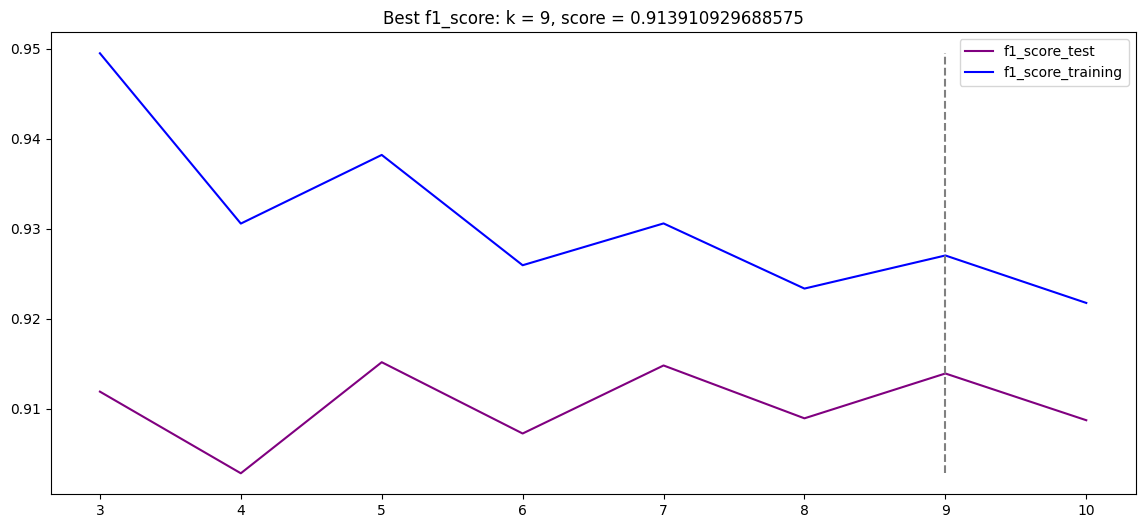

In [59]:
experimento_knn.plotBestParameter()

In [60]:
experimento_knn.getBestMetrics()

{'accuracy': {'training': 0.9391849962076811,
  'test': 0.9275093654655698,
  'valid': 0.9275394961227839},
 'precision': {'training': 0.9658597144630664,
  'test': 0.954493197930638,
  'valid': 0.9548292920282215},
 'recall': {'training': 0.8911798396334479,
  'test': 0.8766388033435988,
  'valid': 0.8741554681119608},
 'f1_score': {'training': 0.9270181709859994,
  'test': 0.913910929688575,
  'valid': 0.9127131782945737},
 'k_neigbors': 9}

## 2.2 - Arvores de decisão

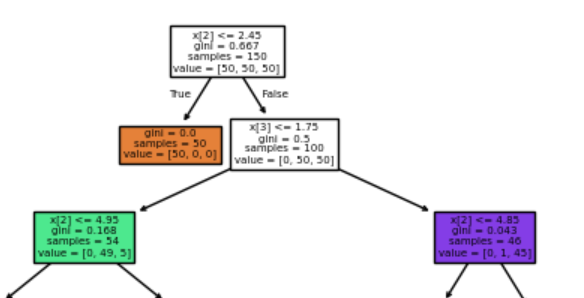

Decision trees, são algoritmos que buscam agrupar os dados por nível de semelhança entre as amostras, a noção de similaridade é alcançada através da ramifição dos dados baseados nas features descritoras. 

Exemplo:
    Clientes com ranges de idades similares (entre 17 - 25 anos) e que possuem distancias de viagens parecidas (menor que 5000 km) podem ser ramificados "juntos" por possuirem uma maior probabilidade de pertecerem a um mesmo grupo. 


Para cada nova amostra que "entra" no algoritmo, a mesma ira percorrer um caminho até um nó "folha". 

Cada nó folha, possuí uma probabilidade de pertencer a uma determinada classe, ou seja, será atribuido a nova amostra a probabilidade do nó em que ela se encontra. 

**Vantagens:**
 * Fáceis de se interpretar - é possível identificar facilmente quais features estão impactando em um resultado. 
 * Extramamente poderosas - a construção do algoritmo, permite que o mesmo desenehe regiões de decisões dos mais diversos formatos (é um algoritmo de classificação não linear) o que torna-o mais adaptável cenários bastante complexos 

 **Desvantagens:**
  * A árvore pode crescer indefinidamente, tornando o algoritmo computacionalmente caro (muitos parametros)
  * Tendem ao overfitting, caso a amostragem dos dados não seja suficientemente representativa da maior parte dos cenários possíveis, o algoritmo tem facilidade em se adaptar muito aos dados, tornando a variabilidade do mundo real dificil de capturar. 


In [10]:

general = y_training.value_counts()
print(f'Quantidade de elementos na classe 0: {general[0]} --> {round(100*general[0]/general.sum(), 2)} %')
print(f'Quantidade de elementos na classe 1: {general[1]} --> {round(100*general[1]/general.sum(), 2)} %')


Quantidade de elementos na classe 0: 41087 --> 56.66 %
Quantidade de elementos na classe 1: 31428 --> 43.34 %


### 2.2.1 - DecisionTree

Text(0.5, 1.0, 'Best Parameter: 15 --- f1_score: 0.932%')

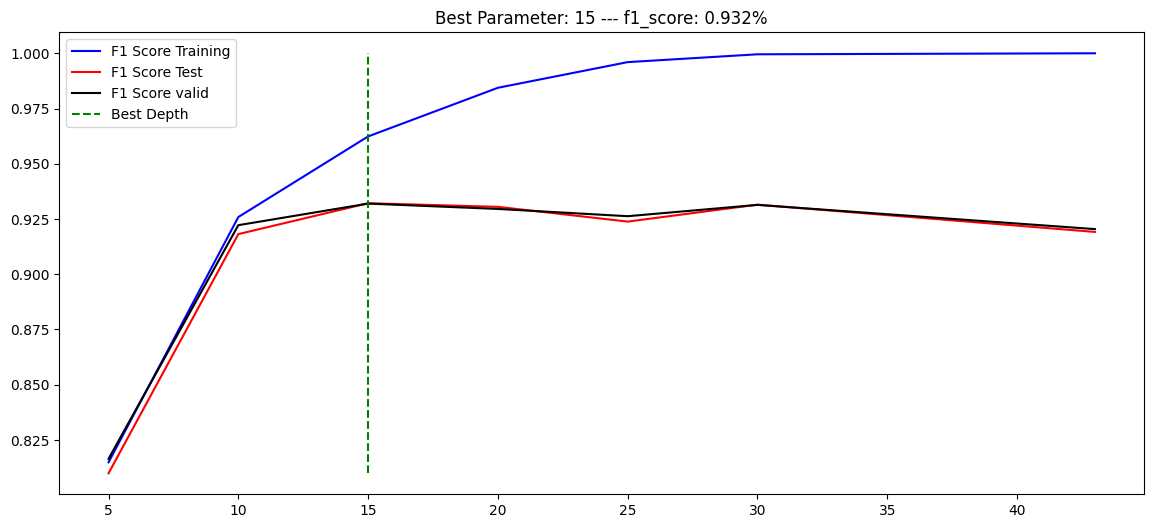

In [68]:
def fineTuningDecisionTree(possible_max_depth):
    results = []
    for depth in possible_max_depth:
        decisionTreeModel = dt(
            max_features='sqrt',
            max_depth=depth  # None means no limit on depth
            #min_samples_leaf=5
            #max_depth=
        )

        decisionTreeModel.fit(X_training_norm, y_training)
        if depth is None:
            depth = decisionTreeModel.get_depth()

        predictions = decisionTreeModel.predict(X_test_normalized)
        predictions_training = decisionTreeModel.predict(X_training_norm)
        predictions_valid = decisionTreeModel.predict(X_valid_norm)


        f1_dt  = mt.f1_score(y_test, predictions)
        f1_training_dt = mt.f1_score(y_training, predictions_training)
        f1_valid_dt= mt.f1_score(y_valid, predictions_valid)
        acc_dt = mt.accuracy_score(y_test, predictions)
        acc_training_dt = mt.accuracy_score(y_training, predictions_training)
        
        pre_dt = mt.precision_score(y_test, predictions)
        rec_dt = mt.recall_score(y_test, predictions)

        results.append({
            'max_depth': depth,
            'f1_score': f1_dt,
            'f1_score_training': f1_training_dt,
            'f1_score_valid'  : f1_valid_dt,
            'accuracy_test': acc_dt,
            'accuracy_training': acc_training_dt,
            'precision': pre_dt,
            'recall': rec_dt
        })
    return results


possible_max_depth = [5, 10, 15, 20, 25, 30,None]
results = fineTuningDecisionTree(possible_max_depth)
depth, f1_score_training, f1_score_test,f1_score_valid = [], [], [], [] 

for r in results: 
    depth.append(r['max_depth']) 
    f1_score_training.append(r['f1_score_training'])
    f1_score_test.append(r['f1_score'])
    f1_score_valid.append(r['f1_score_valid'])


best_valid_idx = f1_score_valid.index(max(f1_score_valid))

plt.figure(figsize=(14,6))
plt.plot(depth, f1_score_training, label='F1 Score Training', color = 'blue')
plt.plot(depth, f1_score_test, label='F1 Score Test', color = 'red')
plt.plot(depth, f1_score_valid, label='F1 Score valid', color = 'black')

plt.vlines(x=depth[best_valid_idx],ymin=min(f1_score_test), ymax=max(f1_score_training), colors='green', linestyles='--', label='Best Depth')
plt.legend()
plt.title(f'Best Parameter: {depth[best_valid_idx]} --- f1_score: {round(f1_score_valid[best_valid_idx],4)}%')

**Arvores possuem forte tendencia ao overfitting.**

Uma abordagem interessante, para reduzir esse risco, é elevar a quantidade minima de elementos em um nó, para ser chamado de folha (em outras palavras, fazer com que o algoritmo pare de expandir ramos antes que haja apenas 1 amostra no novo ramo gerado)

Desta maneira é possível aumentar um pouco mais o viés do modelo, e reduzir sua variancia (o que leva ao overfitting.)

### 2.2.3 - RandomForest

**A mágica das florestas aleatórias**

Se 1 arvore de decisão tem altas chances de overfitting, e se criassemos "k" arvores ligeiramente diferentes entre si? 

A ideia seria basicamente arvore 1 - possui 70% dos dados de treino, amostrados via bootstrapping, arvore 2 - possui 70% dos dados de treino também amostrados via bootstrapping, ou seja, cada arvore vai ver um conjunto de dados ligeiramente diferente... e tem mais, a cada decisão de que feature utilizar para separação dos nós, cada arvore também tera um teor de aleatoriedade, uma vez que definimos que esta decisão deve olhar uma parcela das features (selecionadas ao acaso). 

Desta maneira teremos n estimadores, totalmente diferentes, mas igualmente poderesos, o que diminui muito o risco de overfitting. 

Para esta abordagem , damos o nome de ensemble methods, e como utilizamos somente árvores de decisão neste ensemble, nomeamos de random forest

In [142]:
# max-feature = uma random forest é uma combinação de várias árvores de decisão, geradas baseadas em bootstrapping, para amostragem de cada 
# nova subarvore. esta metodologia busca evitar o overfitting,
#  pois cada arvore é gerada com uma amostra diferente dos dados, a quantidade de dados sera definido pelo max_samples. 
# 
# max_featres: a cada nova ramificação da arvore, 
# o modelo irá considerar apenas uma fração dos atributos disponíveis, para calculo da função de custo, e avaliar sob qual feature realizar a separação. 

class randomForestFineTunning(ExperimentClassification):

    def __init__(self,
            max_depths       : list,
            n_estimators     : list,
            training_dataset : dict = None,
            test_dataset     : dict = None,
            valid_dataset    : dict = None,
            verbose          : bool = True,
            experimentName   : str = 'Experimento'
            ):

        super().__init__(training_dataset,
                    test_dataset,
                    valid_dataset)

        self.parameters = {}

        self.parameters['max_depths']    = max_depths
        self.parameters['n_estimators']  = n_estimators
        
        self.experimentName = experimentName
        self.verbose        = verbose 

    def fineTunningRandomForest(self):
        #max_depths   = [10,15,20]
        #n_estimators = [20,40,60]
        max_depths   = self.parameters['max_depths']
        n_estimators = self.parameters['n_estimators']
        
        
        for estimators in n_estimators:
            print(f'Estimators: {estimators}')
            for depth in max_depths:

                randomForestModel = rf(
                                        n_estimators = estimators,
                                        max_features = 'sqrt',
                                        bootstrap    = True,
                                        max_depth    = depth,
                                        max_samples  = 0.7 ,
                                        n_jobs       = -1
                                    )

                randomForestModel.fit(self.x_training, self.y_training.values.reshape(-1))
                predictions_test     = randomForestModel.predict(self.x_test)
                predictions_training = randomForestModel.predict(self.x_training)
                predictions_valid    = randomForestModel.predict(self.x_valid)
                

                metrics = self.computeMetricsSklearnModel(predictions_training=predictions_training,
                                                          predictions_test=predictions_test,
                                                          predictions_valid=predictions_valid)
                
                metrics['n_estimators'] = estimators
                metrics['max_depths']    = depth

                self.general_metrics.append(metrics)

            
    def plotMetrics(self,
                    parameter : Literal['n_estimators','max_depths'] = 'n_estimators',
                    metric   : Literal['f1_score','accuracy','precision','recall'] = 'f1_score'):

        df = pd.DataFrame(self.general_metrics)
        best_valids,best_tests,best_trainings = [],[],[]

        # Percorre todos os valores testados para um determinado parametro
        for estimator in self.parameters[parameter]:
            
            # busca pelo melhor resultado 
            df_filtred = df[df[parameter] == estimator]
            f1_scores = df_filtred[metric].values
            
            # transforma o dict de reuslts em dataframe para simplificar a manipulacao
            df_f1_scores = pd.DataFrame(f1_scores.tolist())
            

            best_valid      = df_f1_scores.valid.max()
            best_test       = df_f1_scores.test.max()
            best_training   = df_f1_scores.training.max()
            
            best_valids.append(best_valid)
            best_tests.append(best_test)
            best_trainings.append(best_training)

        plt.figure(figsize=(14,6))

        bestMetrics = self.getBestMetrics()
        
        plt.plot(self.parameters[parameter], best_valids   , label = 'valid')
        plt.plot(self.parameters[parameter], best_tests    , label = 'test')
        plt.plot(self.parameters[parameter], best_trainings, label = 'trainning')
        plt.title(f"Best Parameters: N_estimators: {bestMetrics['n_estimators']} -- max_depth: {bestMetrics['max_depths']} -- f1_score valid {bestMetrics['f1_score']['valid']}")
        plt.ylabel(metric)
        plt.xlabel(parameter)
        plt.legend()

        plt.show()
        
        




In [ ]:
max_depths = [10,15,20,25,30,35,45,50]
n_estimators = [10,30,50,100,150]
randomForestExperiment = randomForestFineTunning(
    max_depths=max_depths, 
    n_estimators=n_estimators,
    training_dataset=training_dataset,
    test_dataset=test_dataset,
    valid_dataset=valid_dataset,
    experimentName='RandomForest'
)

randomForestExperiment.fineTunningRandomForest()
randomForestExperiment.plotMetrics()


Estimators: 10
Estimators: 30
Estimators: 50


## 2.3 - Logistic Regression

In [28]:
logistic_regression = lr()
logistic_regression.fit(X_training_norm, y_training)

predictions_training = logistic_regression.predict(X_training_norm)
predictions_test     = logistic_regression.predict(X_test_normalized)

accuracy_training_lr = mt.accuracy_score(y_training, predictions_training)
accuracy_test_lr = mt.accuracy_score(y_test, predictions_test)

f1_score_lr  = mt.f1_score(y_test, predictions_test)
precision_lr = mt.precision_score(y_test, predictions_test)
recall_lr = mt.recall_score(y_test, predictions_test)
print(f'acc training: {(accuracy_training_lr)}')
print(f'acc: {(accuracy_test_lr)}')
print(f'f1: {(f1_score_lr)}')
print(f'precision: {(precision_lr)}')
print(f'recall: {(recall_lr)}')

/home/p123/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


acc training: 0.8759153278632007
acc: 0.8713551925230757
f1: 0.8505808998340286
precision: 0.8675878477306003
recall: 0.8342278926528817


# 3.0 Model Evaluations